## User item collaborating filtering


In a movie rating scenario, we are given users and their movie preferences.
The preferences are ratings between 1-5 where 1 means "I didn't like this movie" and 5 "This movie is awesome". 

The goal is to predict (and recommend) movies to users, based on their preferences, eg predict the rating for a given movie, for a given user.


The collaborative filtering approach makes the basic assumption that there groups of users with similar preferences and that there are factors or categories of movies so that similar people will tend to like similar movies.


If we have $U$ users and $M$ movies, 
we can formulate a representation of this problem with a matrix $A$ with dimensions $UxM$ where $A_{ij}$ will hold the rating of user $j$ for movie $j$  


This matrix looks like this:


<img src="images/recs.jpg"/>


We would like to predict the empty elements in the matrix and recommend movies to users accordingly.


### Latent factors and movie factorization

If we assume that there are $K << M$ unknown factors or movie categories, based on the above, we can assume that each movie has certan weights for each of these factors and similarily, each user has weight preferences for these factors as well. These factors can be thought as a combination of known or unknown properties of the movies, eg genre, director, actors etc.  


So, we can think movie factors as a matrix $W_m$ with dimensions $KxM$ and the users as a matrix $W_u$ with dimensions $UxK$

Then, we can say that the ratings are a linear combination of user preferences and movie categories, so that 
$$ A \approx W_u * W_m$$

This implies a linear relationship (dot product) between user preferences and movie factors, and since K is typically much smaller than M, this is essentially low rank matrix factorisation.


We formulate the matrix factorisation problem as an optimisation problem,
were we seek to minimise the distance between known ratings and predicted ratings in the factorisation problem.


Let's see how we can implement this with pytorch



## MovieLens data set and matrix factorisation


In [1]:
import pandas as pd
import numpy as np
import implicit
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
movies = pd.read_csv("./data/ml-latest-small/movies.csv")

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [6]:
M = movies.shape[0]
U = ratings.userId.unique().shape[0]
U, M


(610, 9742)

In [7]:
id_to_movie = movies[["movieId"]].to_dict()['movieId']
movie_to_idx = { m:i   for i,m in id_to_movie.items() }


## Build the matrix A of user movie ratings

In [8]:
A = np.zeros((U,M), dtype=np.float32)
A.dtype

#from scipy.sparse import csc_matrix
#A = csc_matrix((M, U), dtype=np.float32) #.toarray()

dtype('float32')

In [9]:
for idx, rec in ratings.iterrows():
    
    uid = rec.userId.astype(np.int32)-1
    mid =  movie_to_idx[rec.movieId.astype(np.int32)]
    A[uid][mid] = rec.rating.astype(np.float32) 
    

In [10]:
np.save(  "./data/ml-latest-small/A.npy", A)

In [11]:
import torch

In [12]:
a = np.array( [ 
             [5 ,0, 2, 1, 1, 1, 0, 2, 0],
             [1 ,5, 1, 3, 0, 0, 4, 1, 2],
             [0 ,0, 0, 1, 3, 2, 2, 0 ,5],
             [1 ,1, 3, 1, 0, 5, 3, 1, 3],
             [2 ,2, 5, 4, 2, 0, 1, 2, 1],
             [0 ,0, 5, 0, 1, 3, 2, 3, 2],
             [2 ,3, 0, 2, 0, 1, 0, 0, 0],
             [0 ,0, 0, 0, 5, 0, 2, 1, 4],
        ], dtype=np.float32)

a = np.zeros( (8, 9), dtype=np.float32)
a[0][0] = 1 
a[0][1] = 1 
a = torch.from_numpy(a)
a, a.shape

U, M = a.shape
K =3 

w1 = torch.rand( (U,K), requires_grad=True)*0.01
w2 = torch.rand( (K,M), requires_grad=True)*0.01

b = w1.matmul(w2)
rating_idx =(a!=0).nonzero()
rating_idx


<ipython-input-12-102afca1da57>:25: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  rating_idx =(a!=0).nonzero()


tensor([[0, 0],
        [0, 1]])

### Convert rating matrix to torch object

In [87]:
R = torch.from_numpy(A)
U, M = R.shape
U, M, R.dtype

(610, 9742, torch.float32)

In [287]:
## Number of latent factors

In [266]:
K = 100

In [269]:
from torch.optim import SGD, Adam


## Start with random weights of zero mean and 0.01 variance
W1 = torch.randn( (U,K))*0.01
W2 = torch.randn( (K,M))*0.01

W1.requires_grad = True
W2.requires_grad = True

optimizer = Adam(params = [W1,W2])# lr =0.0001 )
#optimizer = SGD(params = [W1,W2], lr =1 )
  

In [279]:
## use these parameters to regularize the learned weights
l1 = 0.01
l2 = 0.01

epochs = 1000
epoch_plot = []
for epoch in range(epochs):
    
    optimizer.zero_grad()
    #b = 4*torch.sigmoid(W1.matmul(W2))+1
    b = W1.matmul(W2) 
    
    b[b<1] = 1
    b[b>5] = 5
    
    loss = ((R[R!=0] - b[R!=0])**2).sum()  + l1*(W1**2).sum() + l2*(W2**2).sum()


    l = loss.item()
    loss.backward()
    optimizer.step()
    epoch_plot.append( l )
    if epoch % 20 == 0 :
        print( f"epoch {epoch}, loss={loss}")

epoch 0, loss=505777.0625
epoch 20, loss=104822.859375
epoch 40, loss=49175.328125
epoch 60, loss=32024.1875
epoch 80, loss=28012.4453125
epoch 100, loss=26680.34375
epoch 120, loss=26025.40625
epoch 140, loss=25650.599609375
epoch 160, loss=25404.884765625
epoch 180, loss=25222.48828125
epoch 200, loss=25083.802734375
epoch 220, loss=24965.337890625
epoch 240, loss=24877.1875
epoch 260, loss=24803.33984375
epoch 280, loss=24742.041015625
epoch 300, loss=24687.65234375
epoch 320, loss=24634.703125
epoch 340, loss=24577.66796875
epoch 360, loss=24532.03125
epoch 380, loss=24488.607421875
epoch 400, loss=24451.154296875
epoch 420, loss=24413.52734375
epoch 440, loss=24379.732421875
epoch 460, loss=24339.171875
epoch 480, loss=24304.716796875
epoch 500, loss=24276.9375
epoch 520, loss=24245.57421875
epoch 540, loss=24211.0703125
epoch 560, loss=24182.4921875
epoch 580, loss=24146.021484375
epoch 600, loss=24114.55859375
epoch 620, loss=24092.74609375
epoch 640, loss=24072.11328125
epoch 6

### plot the loss function

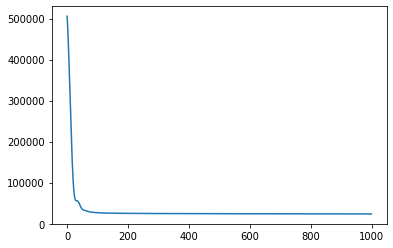

In [280]:
plt.plot( range(epochs), epoch_plot)

In [281]:
W1.shape

torch.Size([610, 100])

### Generate recommendations for a given user

#### Movies rated by this user

In [282]:
usr = 100

user1 = W1[usr,:]

m_ids = ratings[ratings.userId ==usr+1][["movieId", "rating"]].sort_values(by="rating", ascending=False).head(15)
movies.merge( m_ids, on=["movieId"]).sort_values(by="rating", ascending=False)

,movieId,title,genres,rating
1,1093,"Doors, The (1991)",Drama,5.0
2,1719,"Sweet Hereafter, The (1997)",Drama,5.0
3,2318,Happiness (1998),Comedy|Drama,5.0
4,2395,Rushmore (1998),Comedy|Drama,5.0
5,2599,Election (1999),Comedy,5.0
6,2712,Eyes Wide Shut (1999),Drama|Mystery|Thriller,5.0
11,2959,Fight Club (1999),Action|Crime|Drama|Thriller,5.0
12,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy,5.0
14,3174,Man on the Moon (1999),Comedy|Drama,5.0
0,223,Clerks (1994),Comedy,4.0


#### Generate recommendations, rank by estimated rating and filter out already rated movies and movies with estimated rating < 3


In [283]:
ret = user1.matmul(W2)
r, idx = ret.topk(100)
vals = idx.numpy()
vals = [id_to_movie[val] for val in vals]
recs = movies[movies.movieId.isin(vals)].copy()
recs["ratings"] = r.detach().numpy()
recs = recs[recs.ratings>=3]
recs[~recs.movieId.isin(m_ids.movieId.values)].head(n=10)

,movieId,title,genres,ratings
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,7.092897
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,6.506225
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,6.499159
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,6.417907
486,555,True Romance (1993),Crime|Thriller,6.324845
581,714,Dead Man (1995),Drama|Mystery|Western,6.063426
659,858,"Godfather, The (1972)",Crime|Drama,6.053674
684,902,Breakfast at Tiffany's (1961),Drama|Romance,5.993235
694,912,Casablanca (1942),Drama|Romance,5.990624
704,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,5.986041


#### Bonus: Movie Similarity 

In [286]:
test_movie_id = 1196
m = W2[:, movie_to_idx[test_movie_id]]
vals, indexes = torch.topk( m.matmul(W2), k=10)
similar_ids = [ id_to_movie[v] for v in indexes.numpy()]
movies[movies.movieId.isin(similar_ids)]

,movieId,title,genres
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
706,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
863,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
899,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2028,2700,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy|Musical
2765,3703,"Road Warrior, The (Mad Max 2) (1981)",Action|Adventure|Sci-Fi|Thriller
4800,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


In [105]:
model = implicit.als.AlternatingLeastSquares(factors=32, iterations=10)


In [155]:
from scipy import sparse
 
B=sparse.csr_matrix(A)

In [156]:
model.fit(B, show_progress=False)

In [175]:
user_items = B.T.tocsr()


In [193]:
ratings.groupby(by="userId").count().reset_index()

,userId,movieId,rating,timestamp
0,1,232,232,232
1,2,29,29,29
2,3,39,39,39
3,4,216,216,216
4,5,44,44,44
...,...,...,...,...
605,606,1115,1115,1115
606,607,187,187,187
607,608,831,831,831
608,609,37,37,37


In [222]:
userId = 99

ids = ratings[(ratings.userId==userId+1) & (ratings.rating>4)].movieId.values

movies[movies.movieId.isin(ids)]


,movieId,title,genres
15,16,Casino (1995),Crime|Drama
16,17,Sense and Sensibility (1995),Drama|Romance
27,28,Persuasion (1995),Drama|Romance
84,95,Broken Arrow (1996),Action|Adventure|Thriller
140,168,First Knight (1995),Action|Drama|Romance
225,261,Little Women (1994),Drama
326,368,Maverick (1994),Adventure|Comedy|Western
472,539,Sleepless in Seattle (1993),Comedy|Drama|Romance
485,553,Tombstone (1993),Action|Drama|Western
514,597,Pretty Woman (1990),Comedy|Romance


In [223]:
recommendations = model.recommend(userId, user_items)
recommendations

[(35, 1.0334817),
 (958, 0.95087004),
 (383, 0.8994977),
 (2103, 0.8491739),
 (815, 0.84259),
 (436, 0.80875254),
 (577, 0.79066527),
 (2195, 0.7899339),
 (1178, 0.7620723),
 (6, 0.71828675)]

In [224]:
recs = [r for r,_ in recommendations]
movies[movies.index.isin(recs)]

,movieId,title,genres
6,7,Sabrina (1995),Comedy|Romance
35,39,Clueless (1995),Comedy|Romance
383,440,Dave (1993),Comedy|Romance
436,500,Mrs. Doubtfire (1993),Comedy|Drama
577,708,"Truth About Cats & Dogs, The (1996)",Comedy|Romance
815,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
958,1259,Stand by Me (1986),Adventure|Drama
1178,1569,My Best Friend's Wedding (1997),Comedy|Romance
2103,2797,Big (1988),Comedy|Drama|Fantasy|Romance
2195,2918,Ferris Bueller's Day Off (1986),Comedy


In [225]:
movie = 815
# find related items
related = model.similar_items(movie)
rel = [ r for r,_ in related]
sorted(rel)
related

[(815, 1.0),
 (116, 0.69577485),
 (642, 0.68469185),
 (75, 0.6845335),
 (551, 0.67997414),
 (618, 0.6775492),
 (622, 0.67616403),
 (875, 0.66427827),
 (592, 0.65973806),
 (575, 0.6569229)]

In [226]:
movies[movies.index.isin(rel)]

,movieId,title,genres
75,83,Once Upon a Time... When We Were Colored (1995),Drama|Romance
116,141,"Birdcage, The (1996)",Comedy
551,661,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical
575,706,Sunset Park (1996),Drama
592,733,"Rock, The (1996)",Action|Adventure|Thriller
618,783,"Hunchback of Notre Dame, The (1996)",Animation|Children|Drama|Musical|Romance
622,788,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi
642,828,"Adventures of Pinocchio, The (1996)",Adventure|Children
815,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
875,1167,Dear God (1996),Comedy
